# Core Functions #

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import zipfile
import glob
from datetime import datetime
import time

working_directory = '/home/jszou/cs/keenan/'
ameriflux_directory = 'ameriflux/'

all_zip_files = glob.glob(working_directory + ameriflux_directory + "*.zip")

def process_proportion_of_time_elapsed(stamp, start, total_minutes_tracked):
	# format is like 201101010000
	current_time = datetime.strptime(str(stamp), "%Y%m%d%H%M%S")
	start_datetime = datetime.strptime(start, "%Y%m%d%H%M%S")
	return (time.mktime(current_time.timetuple()) - time.mktime(start_datetime.timetuple()))/total_minutes_tracked


def find_total_minutes_tracked(start, end):
	#timestamp is like 201101010000
	start_datetime = datetime.strptime(start, "%Y%m%d%H%M%S")
	end_datetime = datetime.strptime(end, "%Y%m%d%H%M%S")
	return time.mktime(end_datetime.timetuple()) - time.mktime(start_datetime.timetuple())

def get_zip_name(site_name, something):
    return working_directory + ameriflux_directory + 'AMF_' + site_name + '_BASE-BADM_' + something + '.zip'

def who_has_this_column(column_name):
    has_this_column = []
    for f in all_zip_files:
        zf = zipfile.ZipFile(f)
        frame = pd.read_csv(zf.open(zf.namelist()[0]), skiprows=2)
        if column_name in frame.columns.values:
            has_this_column.append(f)
        zf.close()
    return has_this_column

def preprocess(site_name, something):
    zf = zipfile.ZipFile(get_zip_name(site_name, something))
    print('Loading: ' + zf.namelist()[0])
    frame = pd.read_csv(zf.open(zf.namelist()[0]), skiprows=2)
    
    start_timestamp = str(frame.iloc[0, 0])
    end_timestamp = str(frame.iloc[len(frame.index)-1, 1])
    total_minutes = find_total_minutes_tracked(start_timestamp, end_timestamp)

    frame['time_elapsed'] = frame['TIMESTAMP_START'].apply(lambda x: process_proportion_of_time_elapsed(x, start_timestamp, total_minutes))

    print("Total rows: " + str(len(frame.index)))
    print("# Rows missing CO2: " + str(len(frame[frame['CO2'] == -9999.0].index)))
    print()
    zf.close()
    return frame


# df should be preprocessed first
# this split is also for predicting CO2
# returns a test set and a list of training samples
def test_train_split(df, proportion):
    # should we batch the test set up as well?
    test = df[(df['time_elapsed'] >= proportion) & (df['CO2'] != -9999.0)] #make sure test time series comes after train
    train = df[df['time_elapsed'] < proportion]
    
    # batch the training set
    n = len(train.index)
    i = 0
    co2_values = train['CO2']
    sample_ranges = []
    while i < n:
        range_for_training_sample = [0, 0]
        while i < n and co2_values[i] == -9999.0:
            i+=1
        range_for_training_sample[0] = i
        while i < n and co2_values[i] != -9999.0:
            i+=1
        range_for_training_sample[1] = i
        sample_ranges.append(range_for_training_sample)
    train_frames = []
    print(sample_ranges)
    for r in sample_ranges:
        train_frames.append(train.iloc[r[0]:r[1]])
    return test, train_frames

# Sample Visualization 

Loading: AMF_CA-ARB_BASE_HH_1-5.csv
Total rows: 87600
# Rows missing CO2: 18383



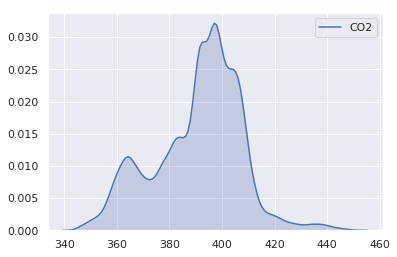

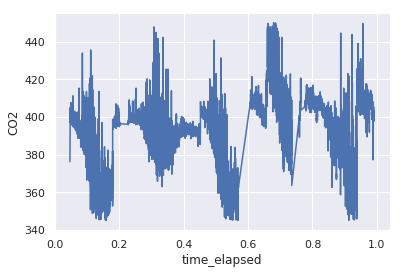

In [2]:
data = preprocess('CA-ARB', '1-5')

sns.set()

sns.kdeplot(data[data['CO2'] > 0]['CO2'], shade=True)
plt.show()

sns.lineplot(x = "time_elapsed", y = "CO2", data=data[data['CO2'] > 0])
plt.show();

# Playing with US-AR1

In [2]:
ar1 = preprocess('US-AR1', '3-5')
ar2 = preprocess('US-AR2', '3-5')
display(ar1.head(), ar2.head(), list(ar1.columns.values) == list(ar2.columns.values))

Loading: AMF_US-AR1_BASE_HH_3-5.csv
Total rows: 70128
# Rows missing CO2: 13390

Loading: AMF_US-AR2_BASE_HH_3-5.csv
Total rows: 70128
# Rows missing CO2: 21970



,TIMESTAMP_START,TIMESTAMP_END,USTAR,TA_1_1_1,WD,WS,FC,H,LE,G,...,SWC_1_2_1,NETRAD,PPFD_IN,SW_IN,PPFD_OUT,SW_OUT,LW_IN,LW_OUT,H2O,time_elapsed
0,200901010000,200901010030,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.000000
1,200901010030,200901010100,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.000001
2,200901010100,200901010130,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.000029
3,200901010130,200901010200,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.000030
4,200901010200,200901010230,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.000057


,TIMESTAMP_START,TIMESTAMP_END,USTAR,TA_1_1_1,WD,WS,FC,H,LE,G,...,SWC_1_2_1,NETRAD,PPFD_IN,SW_IN,PPFD_OUT,SW_OUT,LW_IN,LW_OUT,H2O,time_elapsed
0,200901010000,200901010030,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.000000
1,200901010030,200901010100,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.000001
2,200901010100,200901010130,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.000029
3,200901010130,200901010200,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.000030
4,200901010200,200901010230,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.000057


True

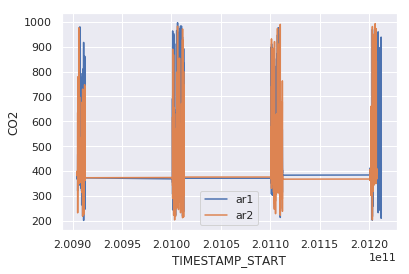

In [35]:
sns.lineplot(x = "TIMESTAMP_START", y = "CO2", data=ar1[ar1['CO2'] != -9999.0], label="ar1")
sns.lineplot(x = "TIMESTAMP_START", y = "CO2", data=ar2[ar2['CO2'] != -9999.0], label='ar2')
plt.show();

In [18]:
test, train = test_train_split(ar1, 0.75)
print(len(train))
for frame in train:
    if len(frame[frame['CO2'] == -9999.0]) > 0:
        print(frame[frame['CO2'] == -9999.0]['CO2'])
display(test.head()['CO2'], train[0].head()['CO2'])

[[5685, 5913], [5914, 6948], [7313, 7625], [7626, 7748], [7749, 9453], [9474, 11036], [11037, 11045], [11060, 11437], [11444, 11481], [11491, 11672], [11684, 11768], [11779, 11784], [11791, 12336], [12720, 13282], [13313, 13336], [13359, 13401], [13407, 13431], [13505, 13538], [13539, 13569], [13605, 13611], [13649, 13669], [13747, 13762], [13792, 13853], [13856, 13962], [14189, 14269], [14332, 14444], [14445, 14823], [14856, 14979], [14980, 14991], [14992, 15281], [15282, 17085], [17087, 17112], [17113, 17470], [17472, 17495], [17496, 17642], [17648, 17796], [17802, 18148], [18150, 18208], [18220, 18264], [18276, 18346], [18349, 18536], [18538, 19333], [19338, 19342], [19343, 19352], [19353, 19938], [19940, 19984], [19998, 20134], [20135, 20691], [20694, 20981], [20983, 21085], [21086, 21769], [21770, 21990], [21991, 22147], [22197, 22205], [22206, 24510], [24511, 25383], [25384, 25386], [25388, 25389], [25390, 25392], [25393, 25812], [25844, 26279], [26280, 27529], [27531, 27887], [2

52596    387.151
52597    389.358
52598    390.537
52599    389.001
52600    389.089
Name: CO2, dtype: float64

5685    375.973
5686    374.991
5687    372.098
5688    370.944
5689    370.206
Name: CO2, dtype: float64

In [41]:
x = who_has_this_column('CO2')
print(len(x))
print(len(x)/len(all_zip_files))

/home/jszou/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/jszou/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/jszou/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (29,38) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/jszou/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (53,87,90,91) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


112
0.43243243243243246


# RNNs and LSTM

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# just train on H, LE, PA_1_1_1, SW_IN, SW_OUT, LW_IN, LW_OUT
predictor_variables = ['H', 'LE', 'PA_1_1_1', 'SW_IN', 'SW_OUT', 'LW_IN', 'LW_OUT']
predicted_variable = 'CO2'
input_dim = 7
hidden_dim = 14
n_layers = 3

# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# train_data = TensorDataset(torch.from_numpy(np.array(ar1[predictor_variables])), torch.from_numpy(np.array(ar1[predicted_variable])))
np.array(test).shape

(11653, 28)

In [ ]:
class CO2Net(nn.Module):
    def __init__(self, input_size, hidden_dim, n_layers, output_size=1, drop_prob=0.5):
        super(CO2Net, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
#         weight = next(self.parameters()).data
#         hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
#                       weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))